# Linear Regression with Pest

This notebooks is a small proof of concept / benchmark comparison between pest and scipy. 

## Packages

In [1]:
import shutil
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import pyemu
import scipy as sc

## Create data

In [2]:
np.random.seed(pyemu.en.SEED)  # set seed

x = np.linspace(0.0, 1.0, 101) # x coordinates
a = 1.0 # slope
b = 10.0 # y-intercept
y = a * x + b # y coordinates
y_noise = y + np.random.normal(loc=0.0, scale=0.1, size=len(x)) # y coordinates with noise

## Scipy Linear Regression

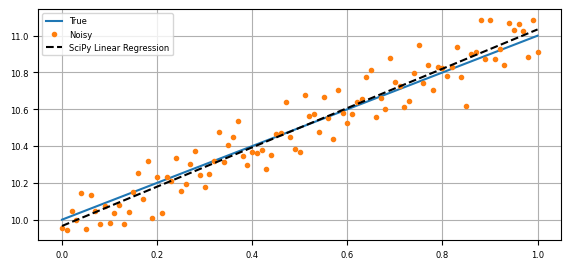

In [3]:
res = sc.stats.linregress(x=x, y=y_noise) # result object
a_fit = res.slope # fitted slope
b_fit = res.intercept # fitted y-intercept

# # add confidence interval
# dof = len(x) - 2 # degrees of freedom
# alpha = 0.05 # probability of confidence interval
# tinv = abs(sc.stats.distributions.t.ppf(alpha/2.0, dof)) # Two-sided inverse Students t-distribution
# a_fit_ci = tinv * res.stderr
# b_fit_ci = tinv * res.intercept_stderr
# lower_bound = (a_fit - a_fit_ci) * x + b_fit - b_fit_ci
# upper_bound = (a_fit + a_fit_ci) * x + b_fit + b_fit_ci

# visualize scipy result
fig, ax = plt.subplots(figsize=(6.75, 3.0))
ax.plot(x, y, label="True")
ax.plot(x, y_noise, marker=".", linestyle="", label="Noisy")
ax.plot(x, a_fit * x + b_fit, color="k", linestyle="--", label="SciPy Linear Regression")
# ax.fill_between(x, lower_bound, upper_bound, color="k", alpha=0.2, label=f"{1-alpha:0.0%} Confidence Interval")
ax.legend()
ax.grid()

## Pest Linear Regression

In [4]:
# setup directories
pest_dir = Path("pestdir")
pest_dir.mkdir() if not pest_dir.exists() else None
temp_dir = Path("template")
temp_dir.mkdir() if not temp_dir.exists() else None
bin_dir = Path("bin")

# parameter bounds
bound = 10.0
a_ini = 0.8
b_ini = 0.2
parameters = pd.DataFrame(
    {
        "optimal": [a, b],
        "pmin": [a - bound, b - bound],
        "pmax": [a + bound, b + bound],
        "initial": [a_ini, b_ini],
    },
    index=pd.Index(["a", "b"], name="parnames"),
    dtype=float,
)
# setup files
par_sel = parameters.loc[:, ["optimal"]]
par_sel.to_csv(pest_dir / "parameters_sel.csv")

observations = pd.Series(y_noise, index=pd.Index(x, name="x"), name="Observations")
observations.to_csv(pest_dir / "simulation.csv")

# create pest optimization with pyemu
pf = pyemu.utils.PstFrom(original_d=pest_dir, new_d=temp_dir, remove_existing=True)
# parameters
pf.add_parameters(
    "parameters_sel.csv",
    index_cols=[par_sel.index.name],
    use_cols=par_sel.columns.to_list(),
    par_type="grid",
    par_style="d",
)
# observations
pf.add_observations(
    "simulation.csv", index_cols=[observations.index.name], use_cols=[observations.name]
)
# python scripts to run
pf.add_py_function(file_name="data/_run_linreg_update.py", call_str="run()", is_pre_cmd=None)
pf.mod_py_cmds.append("run()")

# create control file
pst = pf.build_pst()
pst.parameter_data.loc[:, ["parlbnd", "parubnd"]] = parameters.loc[
    :, ["pmin", "pmax"]
].values  # parameter bounds
pst.control_data.noptmax = 100 # optimization runs
pst.write(pf.new_d / "pest.pst", version=2)

# execute
executable = "pestpp-glm"
shutil.copy(bin_dir / executable, temp_dir)
pyemu.os_utils.run(f"{executable} pest.pst", cwd=pf.new_d)

# get pets results
ipar = pd.read_csv(temp_dir/"pest.ipar", index_col=0).transpose()
a_pest, b_pest = ipar.iloc[:, -1].values

2024-07-25 12:08:25.764986 starting: opening PstFrom.log for logging
2024-07-25 12:08:25.765566 starting PstFrom process
2024-07-25 12:08:25.765788 starting: setting up dirs
2024-07-25 12:08:25.765896 starting: removing existing new_d 'template'
2024-07-25 12:08:25.766125 finished: removing existing new_d 'template' took: 0:00:00.000229
2024-07-25 12:08:25.766247 starting: copying original_d 'pestdir' to new_d 'template'
2024-07-25 12:08:25.766945 finished: copying original_d 'pestdir' to new_d 'template' took: 0:00:00.000698
2024-07-25 12:08:25.767538 finished: setting up dirs took: 0:00:00.001750
2024-07-25 12:08:25.767793 transform was not passed, setting default tranform to 'log'
2024-07-25 12:08:25.767948 starting: adding grid type d style parameters for file(s) ['parameters_sel.csv']
2024-07-25 12:08:25.768050 starting: loading list-style template/parameters_sel.csv
2024-07-25 12:08:25.768104 starting: reading list-style file: template/parameters_sel.csv
2024-07-25 12:08:25.77071

/home/martin/.cache/pypoetry/virtualenvs/pastas-env-yLiFYOJv-py3.10/lib/python3.10/site-packages/pyemu/logger.py:100: PyemuWarning: 2024-07-25 12:08:25.813721 WARNING: add_py_function() command: run() is not being called directly



error removing tmp file:simulation.csv
starting list mlt 2024-07-25 12:08:27.130913
number of chunks to process: 1
null mlt file for org_file 'org/parameters_sel.csv', continuing...
process 0  processed  1 process_list_file calls
finished list mlt 2024-07-25 12:08:27.149298
starting arr mlt 2024-07-25 12:08:27.149411
number of chunks to process: 1
process 0  processed  0 process_array_file calls
finished arr mlt 2024-07-25 12:08:27.149914
parameters view
           optimal
parnames         
a             1.0
b            10.0
07/25/24 12:08:27 foward run command(s) finished, took 1.477 seconds
07/25/24 12:08:27 processing instruction files with 1 threads...
thread 0 processed 1 instruction files
07/25/24 12:08:27 done, took 0 seconds


-->07/25/24 12:08:27 run complete, took: 1.479 seconds
-->1 of 3 complete, 0 failed


07/25/24 12:08:27 processing template files with 1 threads...
thread 0 processed 1 template files
07/25/24 12:08:27 done, took 0 seconds
07/25/24 12:08:27 calling forwa

## Compare result

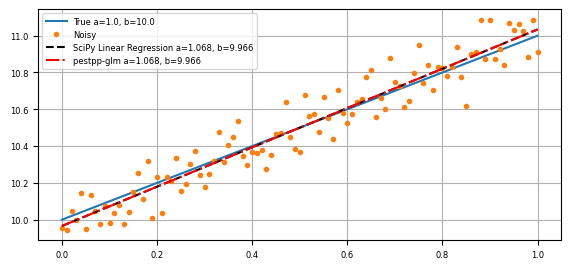

In [5]:
fig, ax = plt.subplots(figsize=(6.75, 3))
ax.plot(x, y, label=f"True {a=}, {b=}")
ax.plot(x, y_noise, marker=".", linestyle="", label="Noisy")
ax.plot(x, a_fit * x + b_fit, color="k", linestyle="--", label=f"SciPy Linear Regression a={a_fit:0.3f}, b={b_fit:0.3f}")
ax.plot(x, a_pest * x + b_pest, color="r", linestyle="-.", label=f"{executable} a={a_pest:0.3f}, b={b_pest:0.3f}")
ax.legend(handlelength=2.5)
ax.grid(True)


## TODO

Add comparison of confidence interval